In [2]:
import argparse
import os
import random
import shutil
import time
import warnings
import ctypes

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import sys; sys.argv=['']; del sys

In [3]:
torch.cuda.is_available()

True

In [4]:
parser = argparse.ArgumentParser(description='Melanoma detection training')
args = parser.parse_args()


In [5]:
best_acc1 = 0
args.world_size = 1
args.multiprocessing_distributed = False
args.dist_url = 'http://localhost:3000'
args.rank = 0
args.gpu = None
args.dist_backend = 'nccl'
args.out_features = 3
args.pretrained = True
args.arch = 'resnext50_32x4d'
args.workers = 4
args.momentum = 0.9
args.lr = 0.01
args.weight_decay = 1e-4
args.data = 'data'
args.batch_size = 64
args.start_epoch = 0
args.epochs = 100
args.save_model = 'resnext50-05092020.pth'
args.evaluate = False
args.print_freq = 2000
args.print_freq_test = 150

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [ ]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, args):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()
    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if args.gpu is not None:
            images = images.cuda(args.gpu, non_blocking=True)
        target = target.cuda(args.gpu, non_blocking=True)

        # compute output
        output = model(images)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            progress.display(i)

In [ ]:
def validate(val_loader, model, criterion, args):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            if args.gpu is not None:
                images = images.cuda(args.gpu, non_blocking=True)
            target = target.cuda(args.gpu, non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq_test == 0:
                progress.display(i)

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg

In [ ]:
def save_checkpoint(state, is_best, filename=args.save_model):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'best_{}'.format(filename))

In [ ]:
def adjust_learning_rate(optimizer, epoch, args):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [ ]:
def main_worker(gpu, ngpus_per_node, args):
    global best_acc1
    args.gpu = gpu
    if args.distributed:
        if args.multiprocessing_distributed:
            # For multiprocessing distributed training, rank needs to be the
            # global rank among all the processes
            args.rank = args.rank * ngpus_per_node + gpu
        dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                world_size=args.world_size, rank=args.rank)
    if args.pretrained:
        print("=> using pre-trained model '{}'".format(args.arch))
        model = models.__dict__[args.arch](pretrained=True)
        
    else:
        print("=> creating model '{}'".format(args.arch))
        model = models.__dict__[args.arch]()
    
    model.fc.out_features = args.out_features
    
    if args.distributed:
        # For multiprocessing distributed, DistributedDataParallel constructor
        # should always set the single device scope, otherwise,
        # DistributedDataParallel will use all available devices.
        if args.gpu is not None:
            torch.cuda.set_device(args.gpu)
            model.cuda(args.gpu)
            # When using a single GPU per process and per
            # DistributedDataParallel, we need to divide the batch size
            # ourselves based on the total number of GPUs we have
            args.batch_size = int(args.batch_size / ngpus_per_node)
            args.workers = int((args.workers + ngpus_per_node - 1) / ngpus_per_node)
            model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
        else:
            model.cuda()
            # DistributedDataParallel will divide and allocate batch_size to all
            # available GPUs if device_ids are not set
            model = torch.nn.parallel.DistributedDataParallel(model)
    elif args.gpu is not None:
        torch.cuda.set_device(args.gpu)
        model = model.cuda(args.gpu)
    else:
        # DataParallel will divide and allocate batch_size to all available GPUs
        if args.arch.startswith('alexnet') or args.arch.startswith('vgg'):
            model.features = torch.nn.DataParallel(model.features)
            model.cuda()
        else:
            model = torch.nn.DataParallel(model).cuda()
    criterion = nn.CrossEntropyLoss().cuda(args.gpu)

    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)
    
    cudnn.benchmark = True
    
    traindir = os.path.join(args.data, 'train')
    valdir = os.path.join(args.data, 'valid')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    train_dataset = datasets.ImageFolder(
        traindir,
        transforms.Compose([
            transforms.RandomRotation(30),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
    
    if args.distributed:
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
    else:
        train_sampler = None
        
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=(train_sampler is None),
        num_workers=args.workers, pin_memory=True, sampler=train_sampler)

    val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)
    
    if args.evaluate:
        validate(val_loader, model, criterion, args)
        return
    
    for epoch in range(args.start_epoch, args.epochs):
        if args.distributed:
            train_sampler.set_epoch(epoch)
        adjust_learning_rate(optimizer, epoch, args)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch, args)

        # evaluate on validation set
        acc1 = validate(val_loader, model, criterion, args)

        # remember best acc@1 and save checkpoint
        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1)

        if not args.multiprocessing_distributed or (args.multiprocessing_distributed
                and args.rank % ngpus_per_node == 0):
            save_checkpoint({
                'epoch': epoch + 1,
                'arch': args.arch,
                'state_dict': model.state_dict(),
                'best_acc1': best_acc1,
                'optimizer' : optimizer.state_dict(),
            }, is_best)

In [ ]:
def main():   
    
    ngpus_per_node = torch.cuda.device_count()
    print(ngpus_per_node)
    args.distributed = args.world_size > 1 or args.multiprocessing_distributed
    
    if args.multiprocessing_distributed:
        args.world_size = ngpus_per_node * args.world_size
        mp.spawn(main_worker, nprocs=ngpus_per_node, args=(ngpus_per_node, ))
    else:
        main_worker(args.gpu, ngpus_per_node, args)

In [ ]:
main()


In [6]:
model = models.resnext50_32x4d(pretrained=True)
model.fc.out_features = args.out_features
model = torch.nn.DataParallel(model).cuda()
m_load = torch.load('best_resnext50-05092020.pth')


In [7]:
model.load_state_dict(m_load["state_dict"])

<All keys matched successfully>

In [8]:
criterion = nn.CrossEntropyLoss().cuda(args.gpu)

optimizer = torch.optim.SGD(model.parameters(), args.lr,
                            momentum=args.momentum,
                            weight_decay=args.weight_decay)

train_on_gpu = torch.cuda.is_available()
data_dir = args.data
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(), 
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=args.batch_size, num_workers=args.workers)


In [8]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))   


In [9]:
test(test_loader, model, criterion, train_on_gpu)

Test Loss: 0.582220


Test Accuracy: 78% (471/600)


In [19]:
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True

import torch.nn.functional as F

from glob import glob 

img_path = np.array(glob("data/test/*/*"))


def predict(img_paths):
    pred_rank1 = [] # Is melanoma?
    pred_rank2 = [] # Is seborrheic?
    transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])])
    img1 = Image.open(img_paths)
    img = transform(img1)
    prediction = model(img[None,:].cuda())
    prediction = F.softmax(prediction, dim=1)
    pred_rank1.append(float(prediction.data[0][0]))
    pred_rank2.append(float(prediction.data[0][2]))
    return pred_rank1, pred_rank2

In [20]:
from tqdm import tqdm


In [21]:
import csv

model.eval()
with open('results.csv', 'w', newline='') as csvfile:
    doc = csv.writer(csvfile)
    doc.writerow(['Id', 'task_1', 'task_2'])
    for i in tqdm(range(len(img_path))):
        pred = predict(img_path[i])
        #print(pred[0][0])
        doc.writerow([img_path[i], pred[0][0], pred[1][0]])

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [07:34<00:00,  1.32it/s]


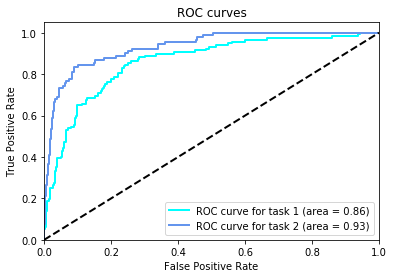

Category 1 Score: 0.859
Category 2 Score: 0.932
Category 3 Score: 0.896


In [22]:
import get_results as results
import pandas as pd

y_true = pd.read_csv('ground_truth.csv')
y_true = y_true[['task_1', 'task_2']].astype(float).to_numpy()

#y_pred = pd.read_csv('sample_predictions.csv')
y_pred = pd.read_csv('results.csv')
y_pred = y_pred[['task_1', 'task_2']].astype(float).to_numpy()

results.plot_roc_auc(y_true, y_pred)